In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.signal import find_peaks

# Load the previously processed data
file_2022_path = '2022.csv'
file_2023_path = '2023c.csv'
file_2024_path = '2024c.csv'

# Read the CSV files
data_2022 = pd.read_csv(file_2022_path)
data_2023 = pd.read_csv(file_2023_path)
data_2024 = pd.read_csv(file_2024_path)

# Combine the data
combined_data = pd.concat([data_2022])
combined_data['Datetime'] = pd.to_datetime(combined_data['Datetime'])
combined_data['Date'] = combined_data['Datetime'].dt.date
combined_data['Time_of_day'] = combined_data['Datetime'].dt.strftime('%H:%M')
combined_data['Hour'] = combined_data['Datetime'].dt.hour  # Add hour for peak timing

# Define time period ranges
periods = {
    '22_to_07': [('22:00', '23:59'), ('00:00', '07:00')],
    '07_to_11': [('07:00', '11:00')],
    '11_to_15': [('11:00', '15:00')],
    '15_to_18': [('15:00', '18:00')],
    '18_to_22': [('18:00', '22:00')]
}

# Function to compute the max price for a time period
def compute_max_price_for_period(data, period):
    time_ranges = periods[period]
    filtered_data = pd.DataFrame()
    for start, end in time_ranges:
        filtered = data[(data['Time_of_day'] >= start) & (data['Time_of_day'] <= end)]
        filtered_data = pd.concat([filtered_data, filtered])
    return filtered_data['USEP (c/kWh)'].max()

# Function to compute the standard deviation of prices for a time period
def compute_std_price_for_period(data, period):
    time_ranges = periods[period]
    filtered_data = pd.DataFrame()
    for start, end in time_ranges:
        filtered = data[(data['Time_of_day'] >= start) & (data['Time_of_day'] <= end)]
        filtered_data = pd.concat([filtered_data, filtered])
    return filtered_data['USEP (c/kWh)'].std()


# Function to compute the average price for a time period
def compute_avg_price_for_period(data, period):
    time_ranges = periods[period]
    filtered_data = pd.DataFrame()
    for start, end in time_ranges:
        filtered = data[(data['Time_of_day'] >= start) & (data['Time_of_day'] <= end)]
        filtered_data = pd.concat([filtered_data, filtered])
    avg_price = filtered_data['USEP (c/kWh)'].mean()
    return avg_price, avg_price > 30

# Function to find the number of peaks (spikes) for each day
def find_day_peaks_and_timings(data):
    prices = data['USEP (c/kWh)'].values
    peaks, _ = find_peaks(prices, prominence=1)  # Adjust prominence as needed
    peak_hours = data['Hour'].iloc[peaks].values

      # Extract the first, second, and third peak hours (if present)
    if len(peak_hours) > 0:
        first_peak_hour = peak_hours[0]
    else:
        first_peak_hour = None

    if len(peak_hours) > 1:
        second_peak_hour = peak_hours[1]
    else:
        second_peak_hour = None

    if len(peak_hours) > 2:
        third_peak_hour = peak_hours[2]
    else:
        third_peak_hour = None

    return len(peaks), first_peak_hour, second_peak_hour, third_peak_hour  # Return num peaks and peak timings


# Group by date and compute max price and standard deviation for each time period
max_std_avg_peaks_per_day = combined_data.groupby('Date').apply(
    lambda x: pd.Series({
        'max_price_22_to_07': compute_max_price_for_period(x, '22_to_07'),
        'max_price_07_to_11': compute_max_price_for_period(x, '07_to_11'),
        'max_price_11_to_15': compute_max_price_for_period(x, '11_to_15'),
        'max_price_15_to_18': compute_max_price_for_period(x, '15_to_18'),
        'max_price_18_to_22': compute_max_price_for_period(x, '18_to_22'),
        'std_price_22_to_07': compute_std_price_for_period(x, '22_to_07'),
        'std_price_07_to_11': compute_std_price_for_period(x, '07_to_11'),
        'std_price_11_to_15': compute_std_price_for_period(x, '11_to_15'),
        'std_price_15_to_18': compute_std_price_for_period(x, '15_to_18'),
        'std_price_18_to_22': compute_std_price_for_period(x, '18_to_22'),
        'avg_price_22_to_07': compute_avg_price_for_period(x, '22_to_07')[0],
        'avg_price_07_to_11': compute_avg_price_for_period(x, '07_to_11')[0],
        'avg_price_11_to_15': compute_avg_price_for_period(x, '11_to_15')[0],
        'avg_price_15_to_18': compute_avg_price_for_period(x, '15_to_18')[0],
        'avg_price_18_to_22': compute_avg_price_for_period(x, '18_to_22')[0],
        'is_avg_above_30_22_to_07': compute_avg_price_for_period(x, '22_to_07')[1],
        'is_avg_above_30_07_to_11': compute_avg_price_for_period(x, '07_to_11')[1],
        'is_avg_above_30_11_to_15': compute_avg_price_for_period(x, '11_to_15')[1],
        'is_avg_above_30_15_to_18': compute_avg_price_for_period(x, '15_to_18')[1],
        'is_avg_above_30_18_to_22': compute_avg_price_for_period(x, '18_to_22')[1],
        'num_peaks': find_day_peaks_and_timings(x)[0], #number of peaks
        'first_peak_hour': find_day_peaks_and_timings(x)[1],  # First peak hour
        'second_peak_hour': find_day_peaks_and_timings(x)[2],  # Second peak hour
        'third_peak_hour': find_day_peaks_and_timings(x)[3]  # Third peak hour
    })
).reset_index()

# Recalculate daily statistics and surge-related features
combined_data['Date'] = combined_data['Datetime'].dt.date
daily_stats = combined_data.groupby('Date')['USEP (c/kWh)'].agg(['mean', 'std', 'max', 'min']).reset_index()
combined_data = pd.merge(combined_data, daily_stats, how='left', left_on='Date', right_on='Date')

# Calculate the surge threshold and determine surges
combined_data['surge_threshold'] = combined_data['mean'] + 2 * combined_data['std']
combined_data['is_surge'] = combined_data['USEP (c/kWh)'] > combined_data['surge_threshold']
combined_data['Time'] = combined_data['Datetime'].dt.time
# Count surges per day and times
surge_info = combined_data[combined_data['is_surge']].groupby('Date').agg(
    num_surges=('is_surge', 'sum')
).reset_index()

# Redefine the function to assign time bins (used earlier)
def assign_time_bin(time):
    if time < pd.to_datetime("07:00:00").time():
        return 'Night'
    elif time < pd.to_datetime("11:00:00").time():
        return 'Morning'
    elif time < pd.to_datetime("15:00:00").time():
        return 'Midday'
    elif time < pd.to_datetime("18:00:00").time():
        return 'Afternoon'
    elif time < pd.to_datetime("22:00:00").time():
        return 'Evening'
    else:
        return 'Night'

# Apply the function to categorize surge times into these bins
combined_data['surge_time_bin'] = combined_data['Time'].apply(assign_time_bin)

# Now, reattempt the previous steps for clustering.
surge_data = combined_data[combined_data['is_surge']]

# Count surges per day in each time bin
time_bin_counts = surge_data.groupby(['Date', 'surge_time_bin']).size().unstack(fill_value=0).reset_index()


# Impute NaN values for peak hours with -1 (to indicate no peak)
max_std_avg_peaks_per_day['first_peak_hour'].fillna(-1, inplace=True)
max_std_avg_peaks_per_day['second_peak_hour'].fillna(-1, inplace=True)
max_std_avg_peaks_per_day['third_peak_hour'].fillna(-1, inplace=True)

# Merge daily features, time bin counts, max/std/avg prices, and number of peaks
complete_features_with_max_std_avg_peaks = pd.merge(surge_info, daily_stats, on='Date', how='left')
complete_features_with_max_std_avg_peaks = pd.merge(complete_features_with_max_std_avg_peaks, time_bin_counts, on='Date', how='left').fillna(0)
complete_features_with_max_std_avg_peaks = pd.merge(complete_features_with_max_std_avg_peaks, max_std_avg_peaks_per_day, on='Date', how='left')

# Prepare features for clustering
features_for_clustering_with_max_std_avg_peaks = complete_features_with_max_std_avg_peaks[[
    #'num_surges',
    #'Morning', 'Midday', 'Evening', 'Afternoon', 'Night',
    #'max', 'mean', 'min',
    #'std',
    #'max',
    'max_price_22_to_07', 'max_price_07_to_11', 'max_price_11_to_15',
    'max_price_15_to_18', 'max_price_18_to_22',
    'std_price_22_to_07', 'std_price_07_to_11', 'std_price_11_to_15',
    'std_price_15_to_18', 'std_price_18_to_22',
    #'avg_price_22_to_07', 'avg_price_07_to_11', 'avg_price_11_to_15',
    #'avg_price_15_to_18', 'avg_price_18_to_22',
    #'is_avg_above_30_22_to_07', 'is_avg_above_30_07_to_11',
    #'is_avg_above_30_11_to_15', 'is_avg_above_30_15_to_18',
    #'is_avg_above_30_18_to_22',
    #'num_peaks',
    #'first_peak_hour', 'second_peak_hour', 'third_peak_hour'
]]

# Normalize the extended feature set
scaler = StandardScaler()
scaled_features_with_max_std_avg_peaks = scaler.fit_transform(features_for_clustering_with_max_std_avg_peaks)

# Apply KMeans clustering for K=2 to K=21
kmeans_results_with_max_std_avg_peaks = {}

for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features_with_max_std_avg_peaks)
    kmeans_results_with_max_std_avg_peaks[k] = clusters

# Create a new DataFrame to store the clustering results for each K
clustered_data_with_max_std_avg_peaks = complete_features_with_max_std_avg_peaks[['Date']].copy()

for k in range(2, 21):
    clustered_data_with_max_std_avg_peaks[f'KMeans_{k}_clusters'] = kmeans_results_with_max_std_avg_peaks[k]

clustered_data_with_max_std_avg_peaks.head()



UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 15-16: invalid continuation byte

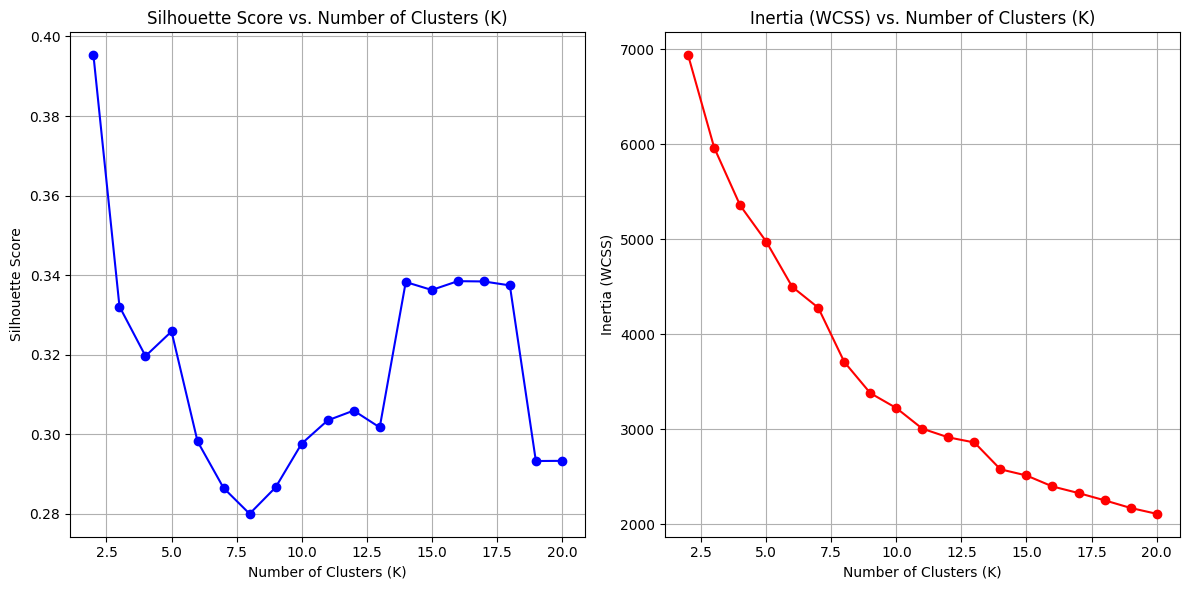

In [ ]:
# Compute silhouette and inertia (WCSS) scores for K=2 to K=21
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silhouette_scores = []
inertia_scores = []

for k in range(2, 21):
    clusters = kmeans_results_with_max_std_avg_peaks[k]
    silhouette_scores.append(silhouette_score(scaled_features_with_max_std_avg_peaks, clusters))
    inertia_scores.append(KMeans(n_clusters=k, random_state=42).fit(scaled_features_with_max_std_avg_peaks).inertia_)

# Plot silhouette and inertia scores vs. K
plt.figure(figsize=(12, 6))

# Silhouette score plot
plt.subplot(1, 2, 1)
plt.plot(range(2, 21), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Inertia score plot
plt.subplot(1, 2, 2)
plt.plot(range(2, 21), inertia_scores, marker='o', linestyle='-', color='r')
plt.title('Inertia (WCSS) vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)

plt.tight_layout()
plt.show()




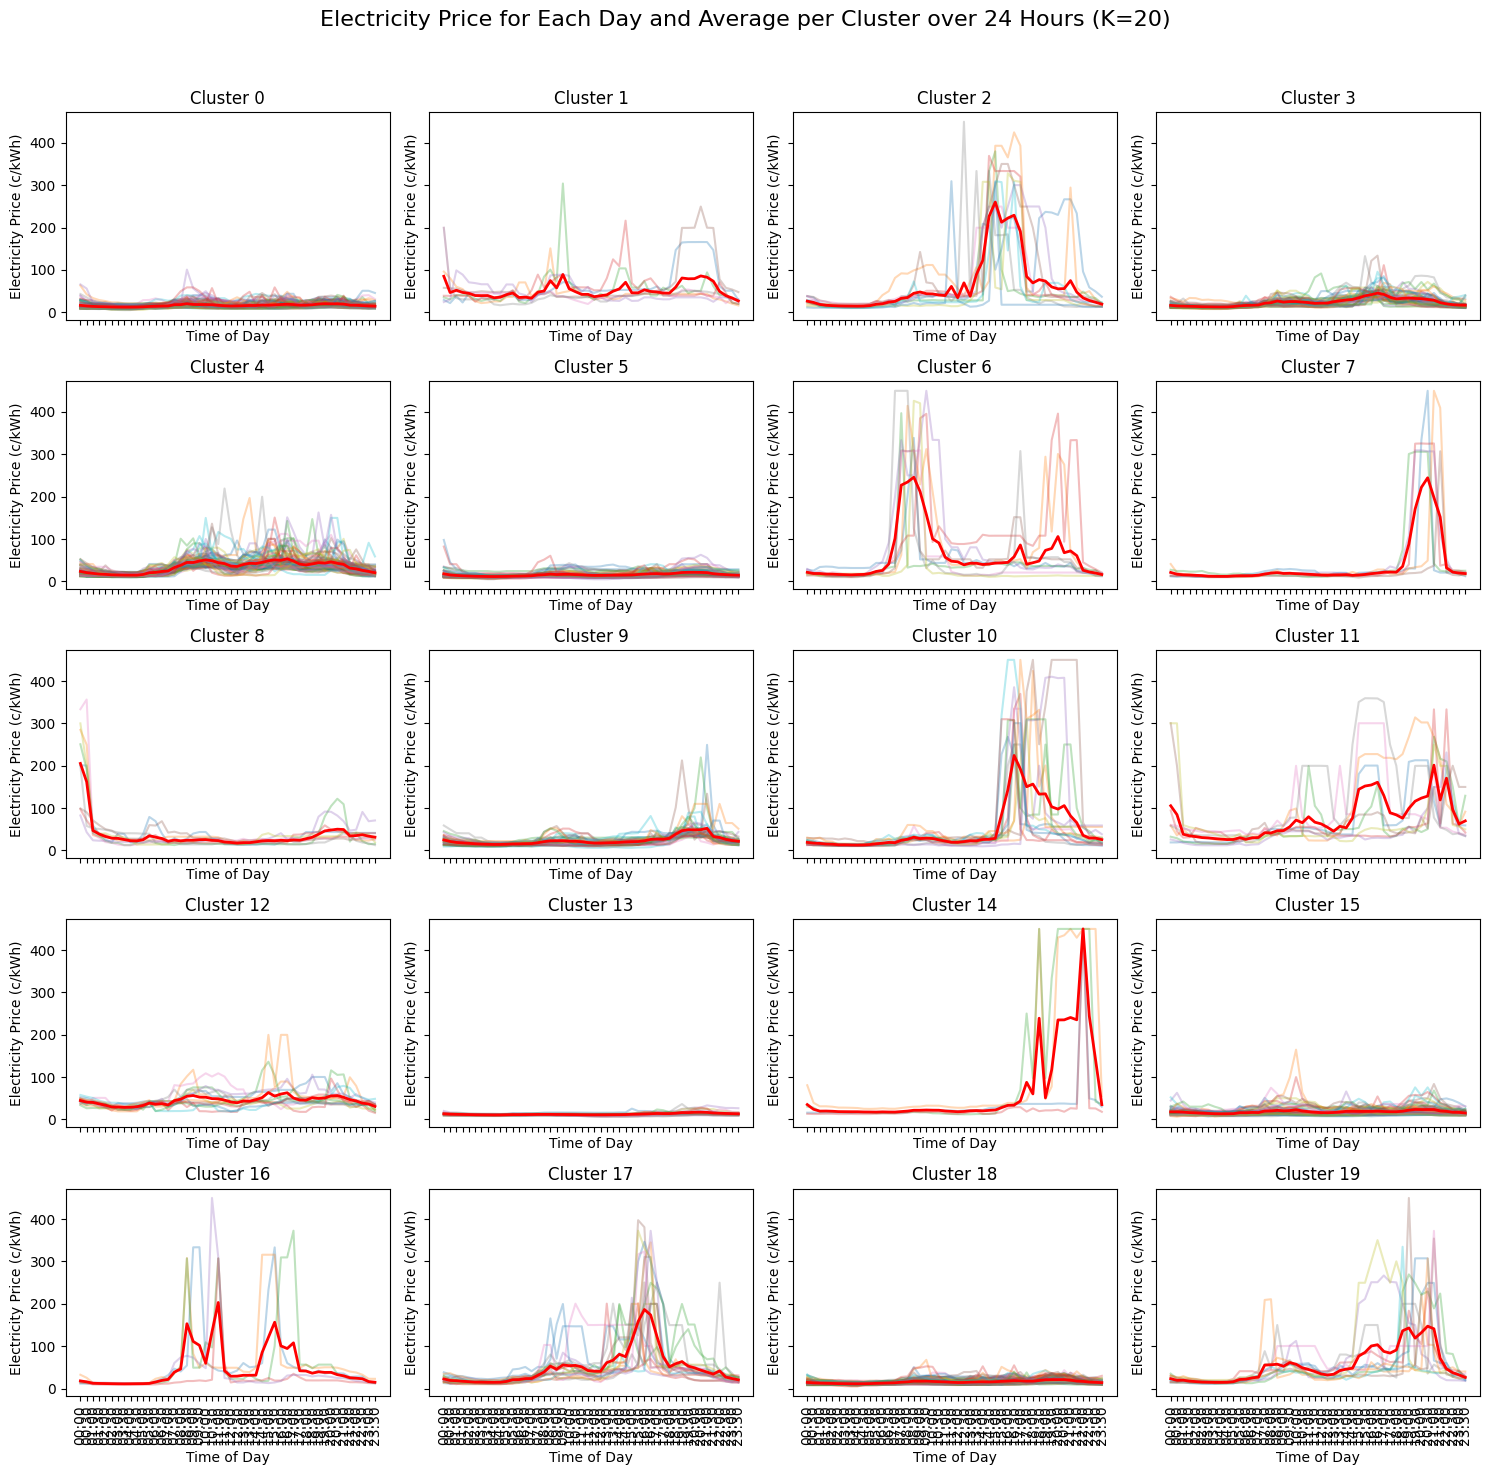

In [ ]:
# First, extract the cluster assignments for K=3
cluster_assignments_k5 = clustered_data_with_max_std_avg_peaks['KMeans_20_clusters']

# Add the cluster assignments to the original combined_data
combined_data_with_clusters_k5 = pd.merge(combined_data,
                                          clustered_data_with_max_std_avg_peaks[['Date', 'KMeans_20_clusters']],
                                          on='Date', how='left')

# Create a new column representing the hour and minute (time of day)
combined_data_with_clusters_k5['Time_of_day'] = combined_data_with_clusters_k5['Datetime'].dt.strftime('%H:%M')

# Group by cluster and time of day to calculate the average electricity price for each cluster
avg_price_per_cluster_k5 = combined_data_with_clusters_k5.groupby(['KMeans_20_clusters', 'Time_of_day'])['USEP (c/kWh)'].mean().unstack()


# Set up the plot with 5 subplots, one for each cluster (K=5)
fig, axes = plt.subplots(5, 4, figsize=(15, 15), sharex=True, sharey=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot electricity price for each day in each cluster (K=6)
for cluster in range(20):

    cluster_data = combined_data_with_clusters_k5[combined_data_with_clusters_k5['KMeans_20_clusters'] == cluster]

    # Group by Date and Time_of_day to plot each day's price
    for date in cluster_data['Date'].unique():
        day_data = cluster_data[cluster_data['Date'] == date]
        axes[cluster].plot(day_data['Time_of_day'], day_data['USEP (c/kWh)'], alpha=0.3)

    # Calculate the average electricity price for each cluster
    avg_price_per_time = cluster_data.groupby('Time_of_day')['USEP (c/kWh)'].mean()

    # Plot the average price as a bold line
    axes[cluster].plot(avg_price_per_time.index, avg_price_per_time.values, color='red', linewidth=2)

    # Set title and labels
    axes[cluster].set_title(f'Cluster {cluster}')
    axes[cluster].set_xlabel('Time of Day')
    axes[cluster].set_ylabel('Electricity Price (c/kWh)')
    axes[cluster].tick_params(axis='x', rotation=90)

# Set a common title and tighten the layout
fig.suptitle('Electricity Price for Each Day and Average per Cluster over 24 Hours (K=20)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [ ]:
# Count the number of days in each cluster for K=5
days_per_cluster_k5 = clustered_data_with_max_std_avg_peaks['KMeans_20_clusters'].value_counts().reset_index()
days_per_cluster_k5.columns = ['Cluster', 'Days']

# Calculate the proportion of days in each cluster
total_days = clustered_data_with_max_std_avg_peaks['Date'].nunique()
days_per_cluster_k5['Proportion (%)'] = (days_per_cluster_k5['Days'] / total_days) * 100

# Sort the table by the number of days in ascending (croissant) order
days_per_cluster_k5_sorted = days_per_cluster_k5.sort_values(by='Days').reset_index(drop=True)

days_per_cluster_k5_sorted


,Cluster,Days,Proportion (%)
0,14,4,0.611621
1,16,5,0.764526
2,7,6,0.917431
3,1,8,1.223242
4,11,9,1.376147
5,8,9,1.376147
6,6,9,1.376147
7,2,11,1.681957
8,19,12,1.834862
9,12,14,2.140673


In [ ]:
# First, extract the cluster assignments for K=6
cluster_assignments_k6 = clustered_data_with_max_prices['KMeans_11_clusters']

# Add the cluster assignments to the original combined_data
combined_data_with_clusters_k6 = pd.merge(combined_data,
                                          clustered_data_with_max_prices[['Date', 'KMeans_11_clusters']],
                                          on='Date', how='left')

# Create a new column representing the hour and minute (time of day)
combined_data_with_clusters_k6['Time_of_day'] = combined_data_with_clusters_k6['Datetime'].dt.strftime('%H:%M')

# Group by cluster and time of day to calculate the average electricity price for each cluster
avg_price_per_cluster_k6 = combined_data_with_clusters_k6.groupby(['KMeans_6_clusters', 'Time_of_day'])['USEP (c/kWh)'].mean().unstack()

# Plot the average electricity price for each cluster over the 24-hour period (K=13)
plt.figure(figsize=(10, 6))

for cluster in range(6):
    plt.plot(avg_price_per_cluster_k6.columns, avg_price_per_cluster_k6.loc[cluster], label=f'Cluster {cluster}')

plt.xticks(rotation=90)
plt.title('Average Electricity Price per Cluster over 24 Hours (K=6)')
plt.xlabel('Time of Day')
plt.ylabel('Average Electricity Price (c/kWh)')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'clustered_data_with_max_prices' is not defined

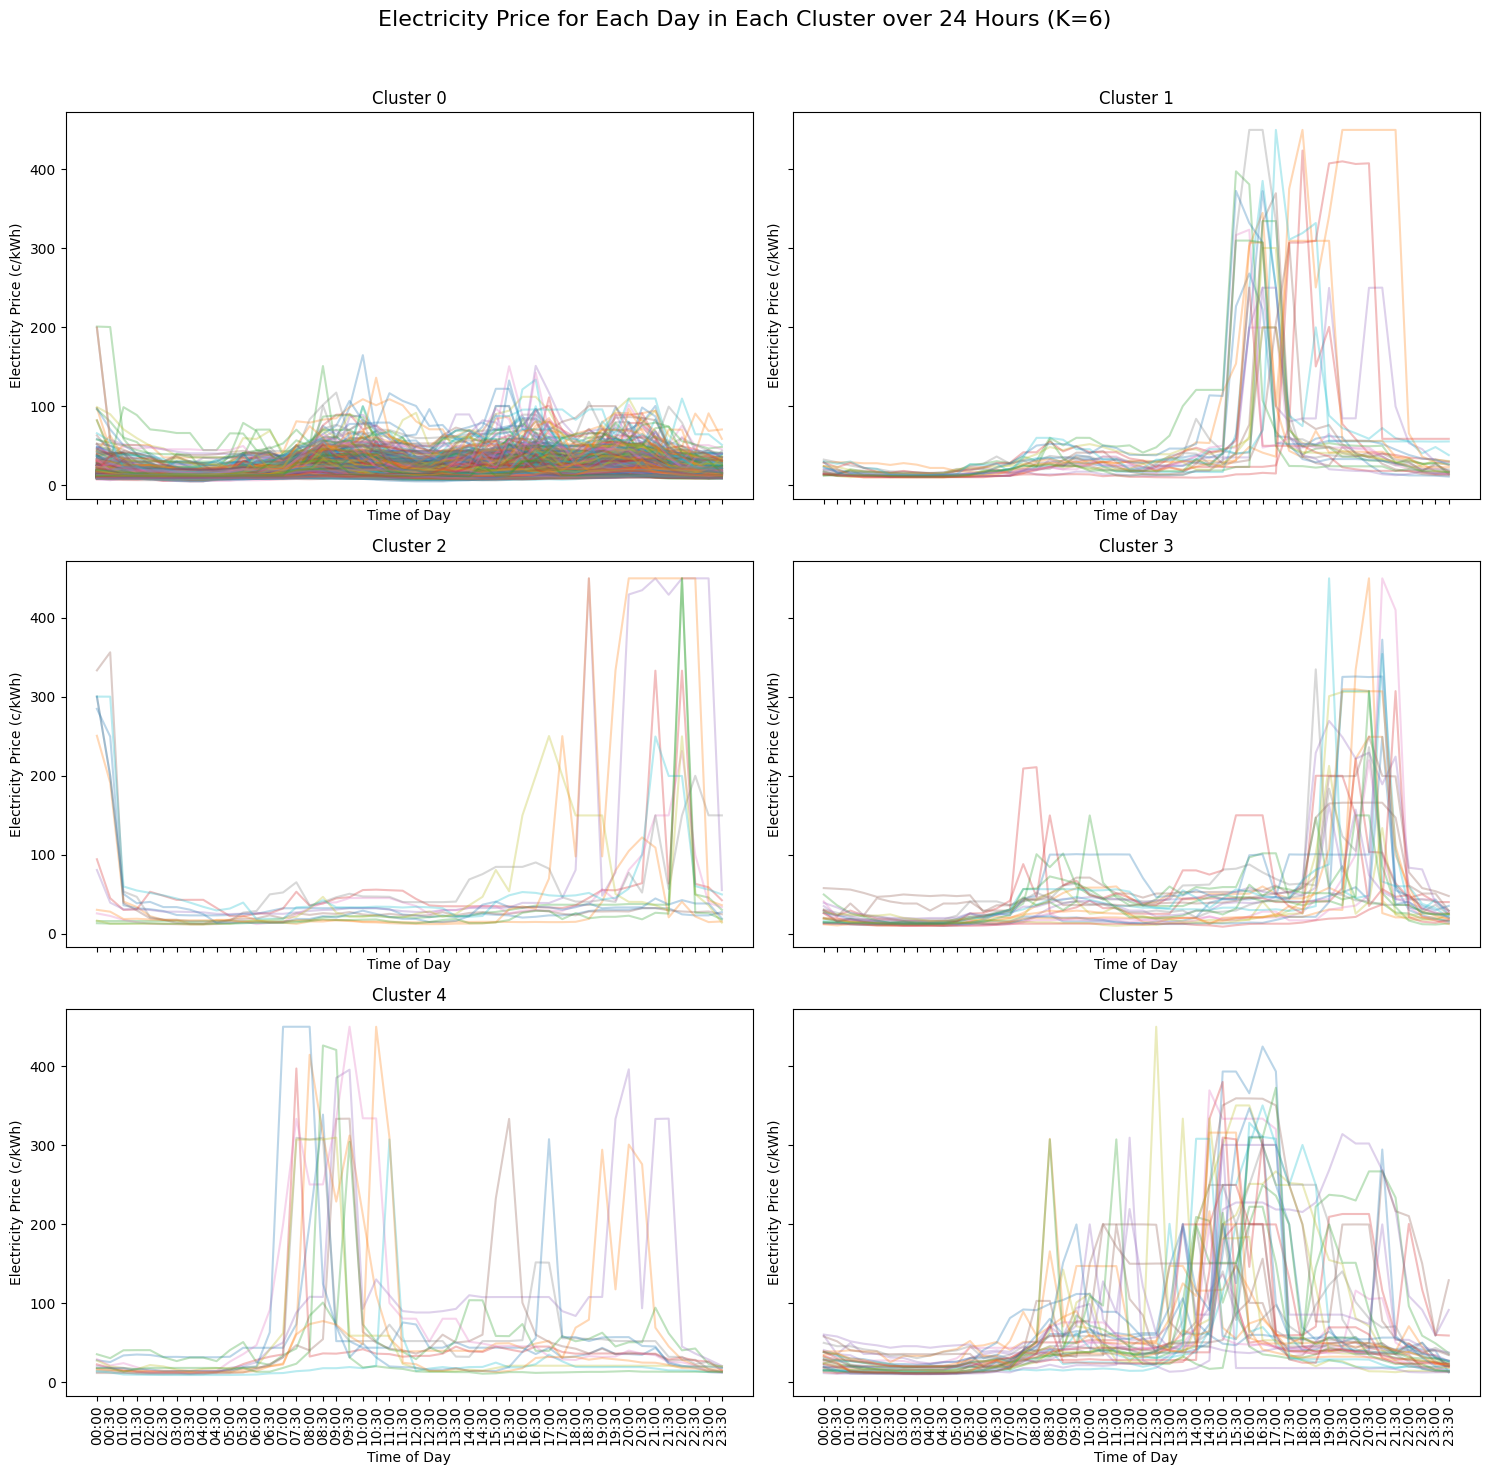

In [ ]:
# Set up the plot with 10 subplots, one for each cluster (K=6)
fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharex=True, sharey=True)

# Flatten the axes array for easier iteration and ignore the extra axis
axes = axes.flatten()

# Plot electricity price for each day in each cluster (K=6)
for cluster in range():
    cluster_data = combined_data_with_clusters_k6[combined_data_with_clusters_k6['KMeans_6_clusters'] == cluster]

    # Group by Date and Time_of_day to plot each day's price
    for date in cluster_data['Date'].unique():
        day_data = cluster_data[cluster_data['Date'] == date]
        axes[cluster].plot(day_data['Time_of_day'], day_data['USEP (c/kWh)'], alpha=0.3)

    # Set title and labels
    axes[cluster].set_title(f'Cluster {cluster}')
    axes[cluster].set_xlabel('Time of Day')
    axes[cluster].set_ylabel('Electricity Price (c/kWh)')
    axes[cluster].tick_params(axis='x', rotation=90)


# Set a common title and tighten the layout
fig.suptitle('Electricity Price for Each Day in Each Cluster over 24 Hours (K=6)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
